<a href="https://colab.research.google.com/github/kmartellluya/fall_22_520_ML_Fairness_Toolkit/blob/main/520_VerifyML_overall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install verifyml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 5.2 MB/s 
     |████████████████████████████████| 295 kB 69.6 MB/s 
     |████████████████████████████████| 965 kB 46.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 2.2.5
    Uninstalling matplotlib-2.2.5:
      Successfully uninstalled matplotlib-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
responsibly 0.1.3 requires matplotlib<3,>=2.2, but you have matplotlib 3.6.2 which is incompatible.


In [3]:
!pip install tempeh
from tempeh.configurations import datasets
compas_dataset = datasets["compas"]()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)

X_train.loc[0], y_train[0]

(age                        25.000000
 juv_fel_count               0.000000
 juv_misd_count             -2.340451
 juv_other_count             1.000000
 priors_count              -15.010999
 age_cat_25 - 45             1.000000
 age_cat_Greater than 45     0.000000
 age_cat_Less than 25        0.000000
 c_charge_degree_F           0.000000
 c_charge_degree_M           1.000000
 Name: 0, dtype: float64, 1.0)

In [62]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit with a path to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [63]:
!pip install responsibly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-2.2.5-cp38-cp38-linux_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
verifyml 0.0.6 requires matplotlib>=3.2.0, but you have matplotlib 2.2.5 which is incompatible.
plotnine 0.8.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.5 which is incompatible.
mizani 0.7.3 requires matplotlib>=3.1.1, but you have matplotlib 2.2.5 which is incompatible.
datascience 0.17.5 requires matplotlib>=3.0.0, but you have matplotlib 2.2.5 which is incompatible.
arviz 0.12.1 requires matplotlib>=3.0, but you have matplotlib 2.2.5 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns

from responsibly.dataset import COMPASDataset
from responsibly.fairness.metrics import distplot_by

In [3]:
compas_ds = COMPASDataset()
df = compas_ds.df

len(df)

6172

In [4]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [5]:
(((df['race'].value_counts() / len(df))
  * 100)
 .round(2))

African-American    51.44
Caucasian           34.07
Hispanic             8.25
Other                5.56
Asian                0.50
Native American      0.18
Name: race, dtype: float64

In [6]:
pd.crosstab(df['sex'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [7]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit with a path to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [8]:
# You can add free text fields
model_card.model_details.name = 'Compass Dataset'


In [9]:


import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline


import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)



In [10]:
#x = df.drop(["two_year_recid","dob","compas_screening_date","v_screening_date","in_custody","out_custody","c_jail_in","c_jail_out","c_offense_date","c_arrest_date"
#,"r_offense_date","r_jail_in","r_jail_out","vr_offense_date","screening_date",],axis=1)
x=df[['race','sex']]
y = df["two_year_recid"]


# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=2, max_features="sqrt", random_state = 88))])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)


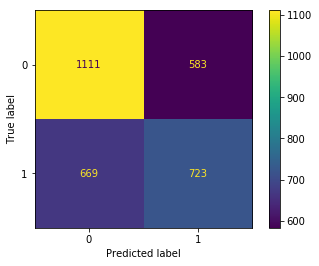

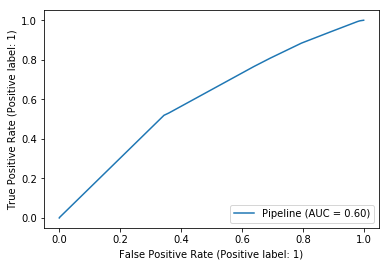

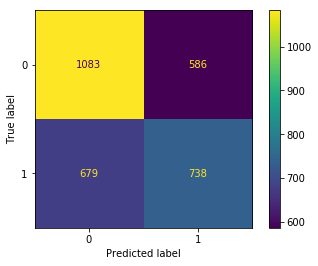

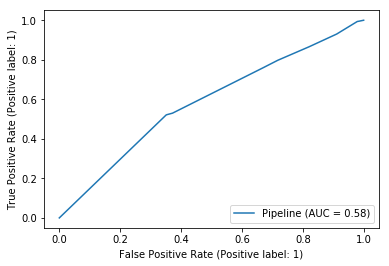

In [11]:

# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()


In [12]:

from verifyml.model_tests.FEAT import SubgroupDisparity
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(5, size=6172)
sgd_test = SubgroupDisparity(
    attr='race',
    metric='fpr',
    method='ratio',
    threshold=2,  
)
sgd_test.run(df)

True

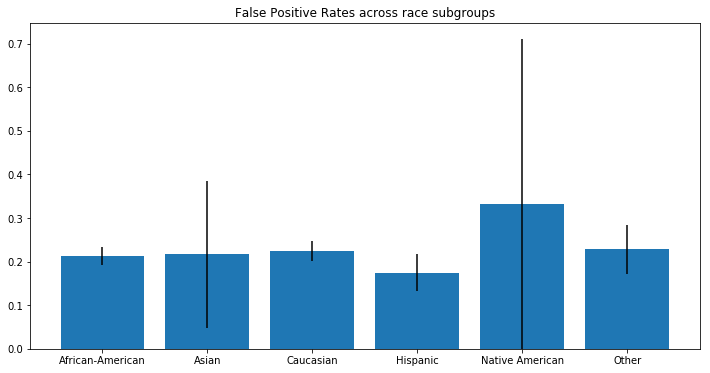

In [13]:

sgd_test.plot()

In [17]:
from verifyml.model_tests.FEAT import MinMaxMetricThreshold
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
min_max_test = MinMaxMetricThreshold(
    attr='sex',
    metric='mae',
    threshold=0.025
)
min_max_test.run(df)

False

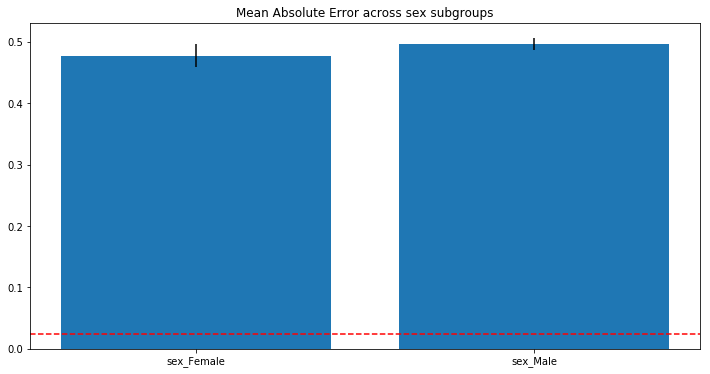

In [18]:
min_max_test.plot()

In [19]:
from verifyml.model_tests.FEAT import SubgroupDisparity
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
sgd_test = SubgroupDisparity(
    attr='sex',
    metric='fpr',
    method='ratio',
    threshold=2,  
)
sgd_test.run(df)

True

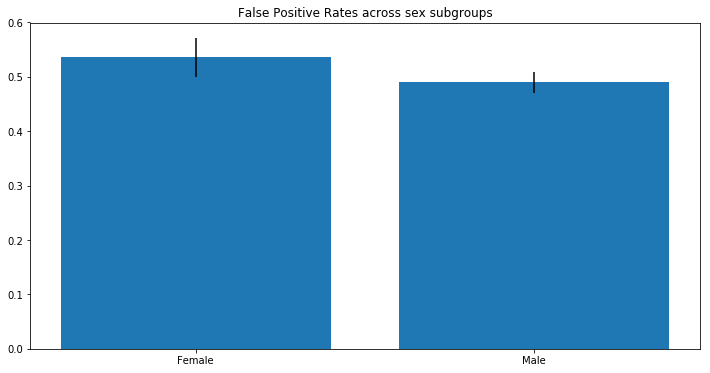

In [20]:
sgd_test.plot()

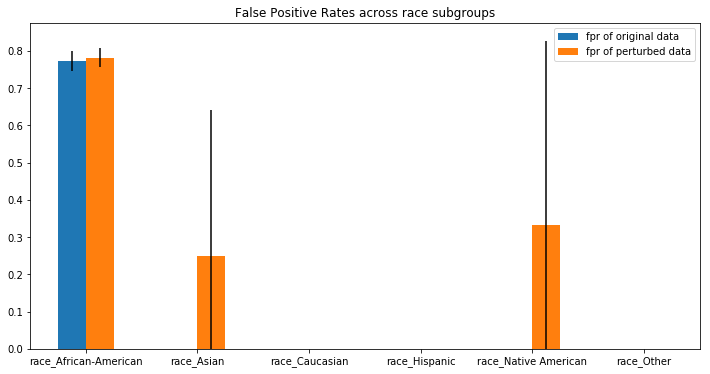

In [21]:
# Subgroup Perturbation Test

np.random.seed(8)
pmt = Perturbation(
    attr='race',
    metric='fpr',
    method='ratio',
    threshold=2,
    #proba_threshold=0.6,  # Outcome probability threshold, default at 0.5
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=estimator[0],
    model=estimator[-1]
)

pmt.plot(alpha=0.07)   

model_output = "margin" has been renamed to model_output = "raw"


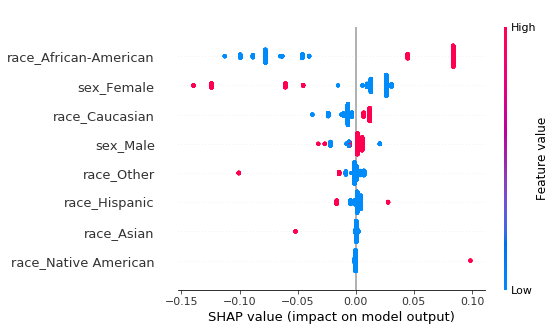

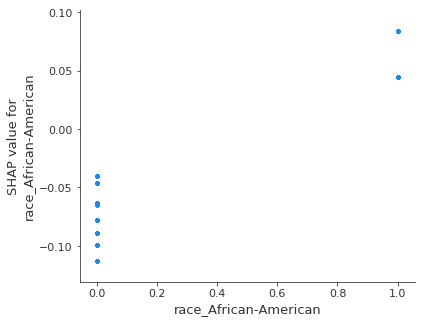

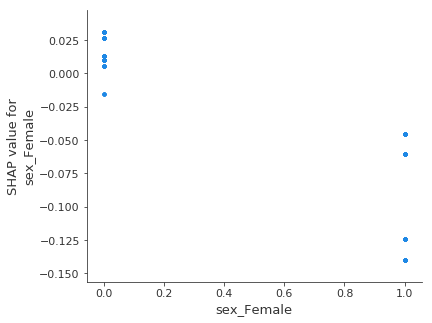

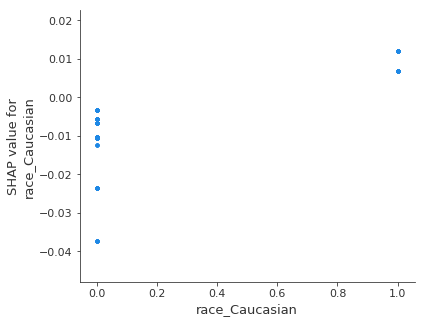

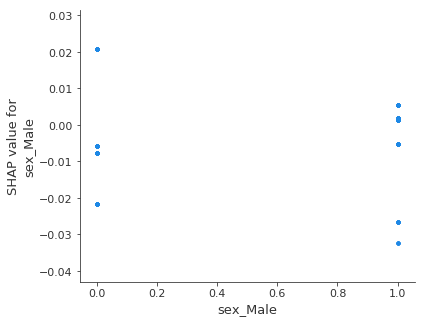

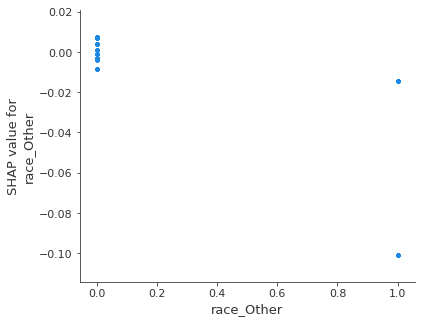

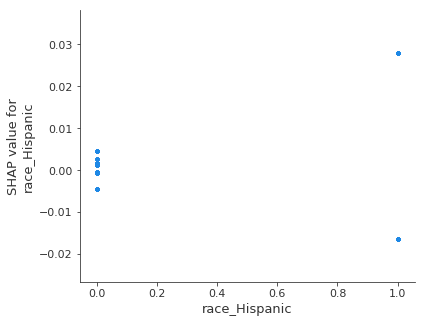

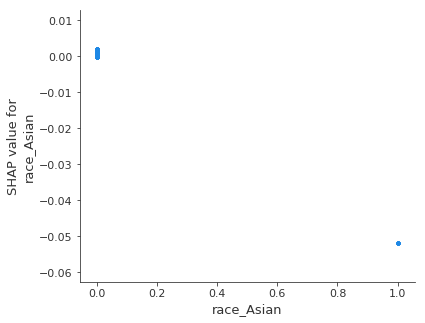

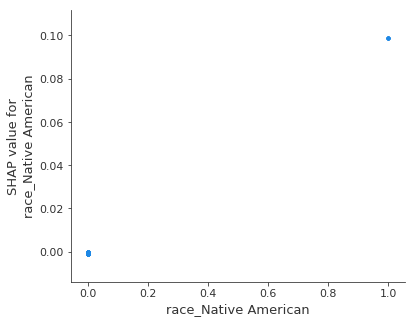

In [22]:
shap_test = SHAPFeatureImportance(
    attrs=['race','sex'],
    threshold=10
)

shap_test.run(
    model=estimator[-1],
    model_type='trees',
    x_train_encoded=x_train_encoded,
    x_test_encoded=x_test_encoded,
)
shap_test.shap_summary_plot(x_test_encoded)
shap_test.shap_dependence_plot(x_test_encoded, show_all=False)

In [23]:
#x = df.drop(["two_year_recid","dob","compas_screening_date","v_screening_date","in_custody","out_custody","c_jail_in","c_jail_out","c_offense_date","c_arrest_date"
#,"r_offense_date","r_jail_in","r_jail_out","vr_offense_date","screening_date",],axis=1)
x=df[["age_cat",
  "age",
  "juv_fel_count",
  "decile_score",
  "juv_misd_count",
  "juv_other_count",
  "priors_count",
  "days_b_screening_arrest",
  "c_case_number",
  "c_charge_degree",
  "c_charge_desc",
  "is_recid",
  "r_charge_degree",
  "is_violent_recid"]]
y = df["two_year_recid"]


# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=2, max_features="sqrt", random_state = 88))])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)

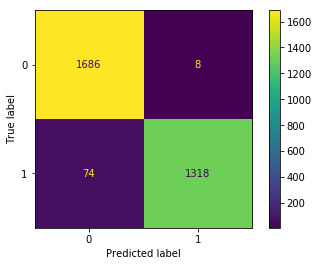

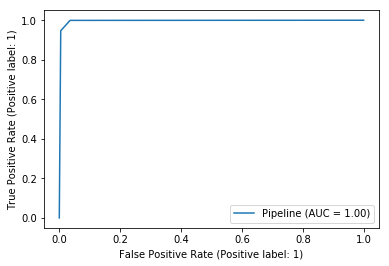

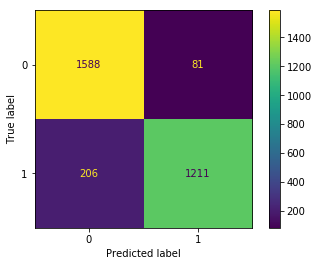

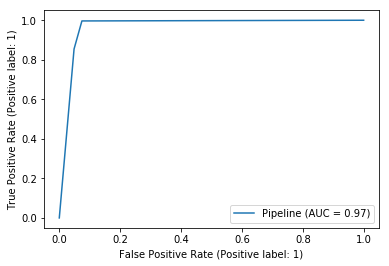

In [24]:
# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

In [25]:
from verifyml.model_tests.FEAT import SubgroupDisparity
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(5, size=6172)
sgd_test = SubgroupDisparity(
    attr='age_cat',
    metric='fpr',
    method='ratio',
    threshold=2,  
)
sgd_test.run(df)

True

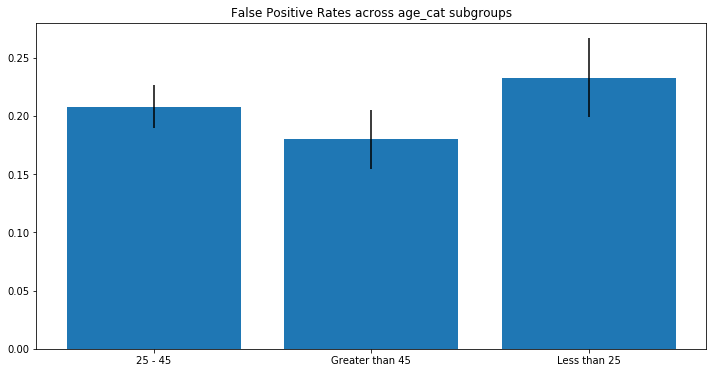

In [26]:
sgd_test.plot()